# WICCA: Wavelet-based Image Compression & Classification Analysis

WICCA is a research framework exploring the impact of wavelet compression on image classification performance.
The goal is to assess whether reducing image size via Haar wavelet transformation retains enough information for accurate classification.

### Objectives
- Apply Haar wavelet compression to large images (>2K resolution).
- Evaluate classification performance on both original and compressed images.
- Compare results across multiple pre-trained models.


## Imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras.applications as apps
from settings.constants import SIM_CLASSES, SIM_CLASSES_PERC, SIM_BEST_CLASS

import utility.result_manager as rsltmgr
from utility.data_loader import load_image
from utility.wavelet_coder import HaarCoder
from utility.classifying_tools import load_classifier, ClassifierProcessor

%matplotlib inline

Load a sample image before and after Haar compression

## Models
Trained image classifiers: https://keras.io/api/applications/

In [2]:
classifiers = {
    'MobileNetV2': load_classifier(apps.mobilenet_v2.MobileNetV2),
    'VGG16': load_classifier(apps.vgg16.VGG16),
    'VGG19': load_classifier(apps.vgg19.VGG19),
    'ResNet50': load_classifier(apps.resnet50.ResNet50),
    'NASNetMobile': load_classifier(apps.nasnet.NASNetMobile),
    'NASNetLarge': load_classifier(apps.nasnet.NASNetLarge, shape=(331, 331))
}

## Analysis

### Data
First let's have a look on our images.

Number of images: 130


Text(0.5, 1.0, 'pp_124.jpg, shape: (5399, 8099, 3)')

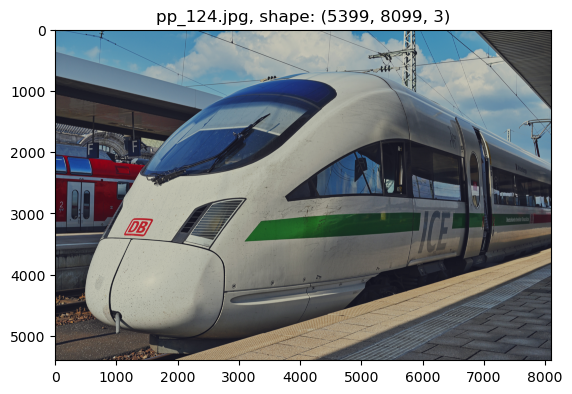

In [3]:
path = 'data/orig'
list_dir = os.listdir(path)
print('Number of images:', len(list_dir))

# Sample
index = 35

name = list_dir[index]
# sample = load_image(f'{drive_path}/{name}')
sample = load_image(f'{path}/{name}')

plt.imshow(sample)
plt.title(f'{name}, shape: {sample.shape}')

We can say this is one of the core functions in the framework that starts our analysis.
In the future, I am going to implement some better error handling and work more with the timer. For now, the timer just shuts down the whole process and does not take into consideration what classifiers are currently working.

**Please be aware, that process might take quite a while.** For reference, analysis of 130 images with resolution around 6000x4000 pixels takes around 15 minutes.

In [4]:
depth = 5
results_folder = os.path.join("results", f"depth_{depth}")
processor = ClassifierProcessor(path=path,
                                coder=HaarCoder(),              # defines our wavelet
                                depth=5,                        # defines the depth of transforming
                                top=5,                          # defines top classes for comparison
                                interpolation=cv2.INTER_AREA,
                                results_folder= results_folder,
                                rsltmgr=rsltmgr)

results = processor.process_all_classifiers(classifiers, timeout=3600)

Let's have a look on how our image was transformed

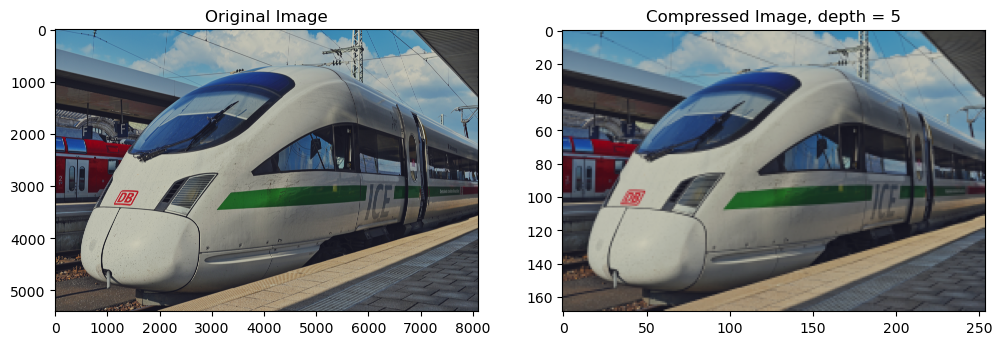

Original size: (5399, 8099, 3)
Compressed size: (169, 254, 3)


In [5]:
processor.show_image_vs_icon(sample)

 ## For current depth
Let's look on classifying comparison with one certain depth

### MobileNetV2

We can call results either by result_manager method

In [6]:
rsltmgr.load_summary_results(depth, 'MobileNetV2')

,Unnamed: 0,similar classes (count),similar classes (%),similar best class
0,count,130.000000,130.000000,130.000000
1,mean,4.046154,80.923077,0.761538
2,std,0.745649,14.912986,0.427791
3,min,2.000000,40.000000,0.000000
4,25%,4.000000,80.000000,1.000000
5,50%,4.000000,80.000000,1.000000
6,75%,5.000000,100.000000,1.000000
7,max,5.000000,100.000000,1.000000


### VGG16

Or by directly looking into "results" dataframe

In [7]:
results['VGG16']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.507692,90.153846,0.815385
std,0.649939,12.998784,0.389486
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,5.000000,100.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### VGG19

In [8]:
results['VGG19']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.584615,91.692308,0.876923
std,0.581159,11.623183,0.329796
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,5.000000,100.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### ResNet50

In [9]:
results['ResNet50']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.323077,86.461538,0.861538
std,0.706727,14.134544,0.346720
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,4.000000,80.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### NASNetMobile

In [10]:
results['NASNetMobile']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.392308,87.846154,0.892308
std,0.687611,13.752216,0.311191
min,2.000000,40.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,4.500000,90.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### NASNetLarge

In [11]:
results['NASNetLarge']

,similar classes (count),similar classes (%),similar best class
count,130.000000,130.000000,130.000000
mean,4.238462,84.769231,0.846154
std,0.814632,16.292643,0.362197
min,1.000000,20.000000,0.000000
25%,4.000000,80.000000,1.000000
50%,4.000000,80.000000,1.000000
75%,5.000000,100.000000,1.000000
max,5.000000,100.000000,1.000000


### Compare classifiers

In [13]:
names = []
mean_sim_clas_perc = []
mean_sim_best_clas = []

for name, df in results.items():
  names.append(name)
  mean_sim_clas_perc.append(df.iat[1, 1])
  mean_sim_best_clas.append(df.iat[1, 2] * 100)

### Similar classes

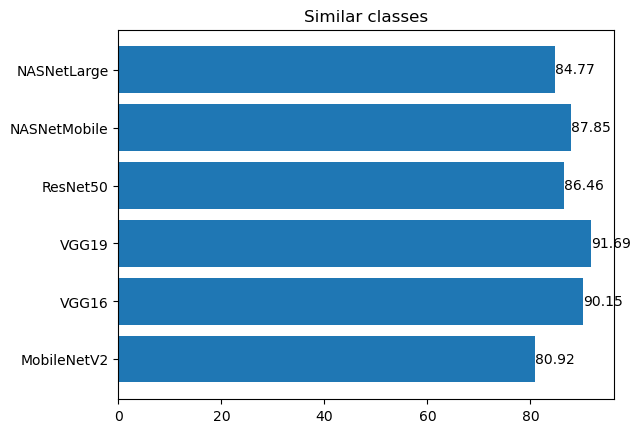

In [14]:
args = list(range(len(names)))

plt.barh(args, mean_sim_clas_perc)

for i, value in enumerate(mean_sim_clas_perc):
    plt.text(value + 0.01, i, f'{value:.2f}', va='center')

plt.yticks(args, labels=names)
plt.title('Similar classes')
plt.show()

### The best class similarity

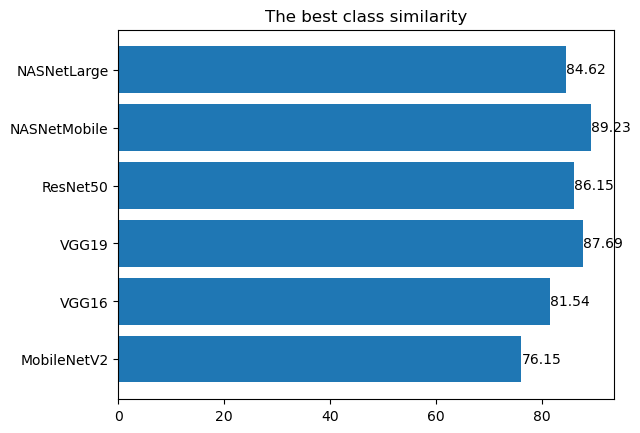

In [15]:
args = list(range(len(names)))

plt.barh(args, mean_sim_best_clas)

for i, value in enumerate(mean_sim_best_clas):
    plt.text(value + 0.01, i, f'{value:.2f}', va='center')

plt.yticks(args, labels=names)
plt.title('The best class similarity')
plt.show()

##  Results comparison for different depths
In this block we compare values by different metrics

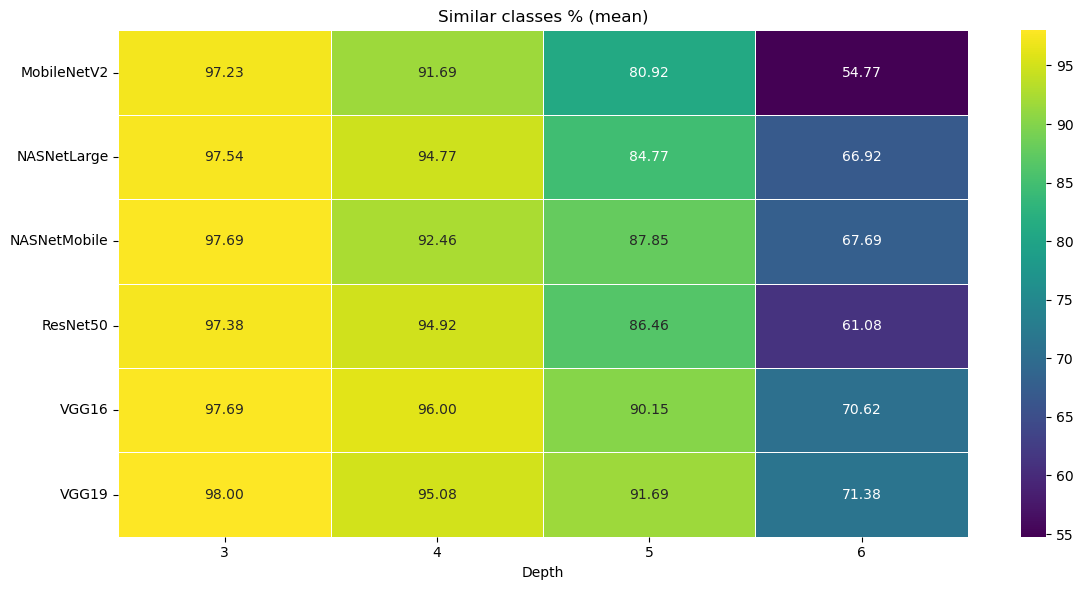

In [16]:
# classifiers = ['MobileNetV2', 'VGG16', 'VGG19', 'ResNet50', 'NASNetMobile', 'NASNetLarge']
depths = [3, 4, 5, 6]

x = rsltmgr.compare_summaries(classifiers, depths, "mean")
rsltmgr.visualize_comparison(x, SIM_CLASSES_PERC, title="Similar classes % (mean)")

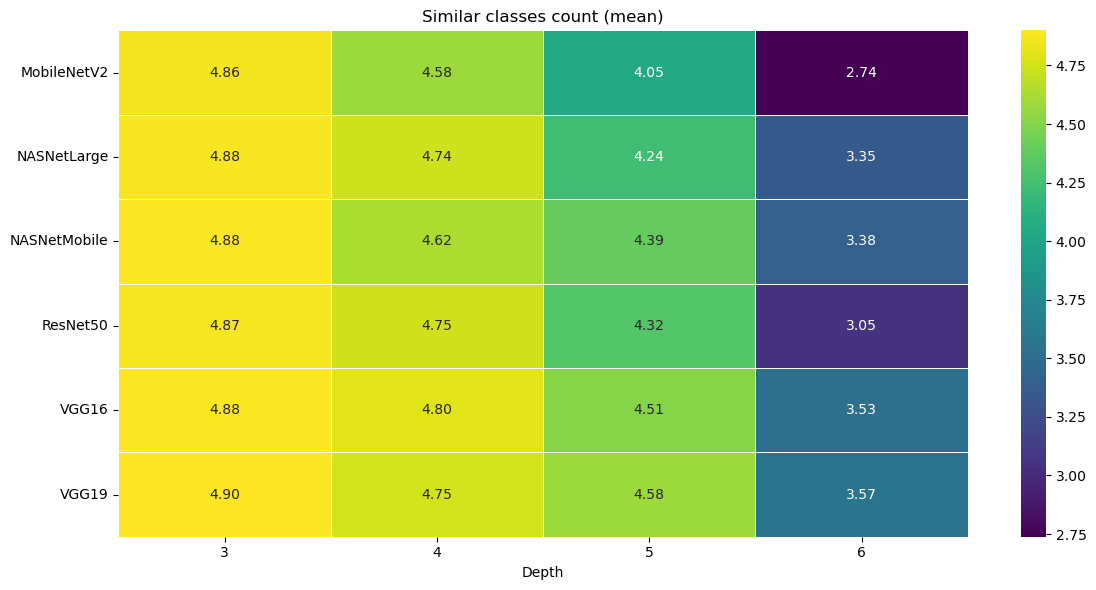

In [17]:
rsltmgr.visualize_comparison(x, SIM_CLASSES, title="Similar classes count (mean)")

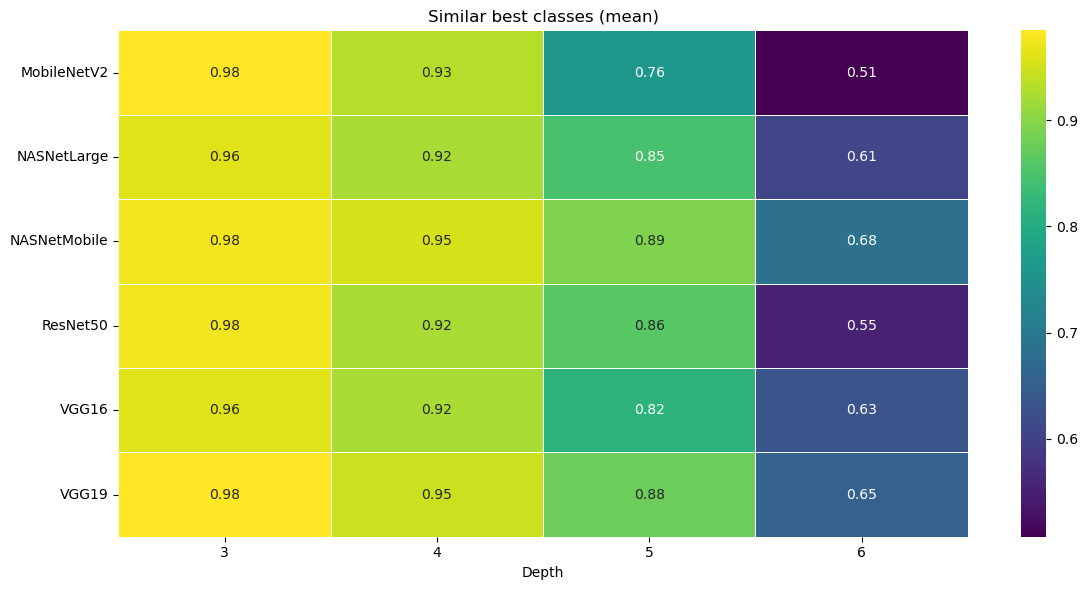

In [18]:
rsltmgr.visualize_comparison(x, SIM_BEST_CLASS, title="Similar best classes (mean)")

## Key Insights & Takeaways

- **Effect of Haar Compression:** The transformation significantly reduces image size but retains recognizable features.
- **Model Performance:** Some models (e.g., ResNet, NASNet) handle compressed images better than others.
- **Trade-offs:** Compression reduces computational cost but may slightly impact accuracy, depending on the classifier.
- **Next Steps:** Extend analysis to other wavelet types (Daubechies, Coiflet) and test on additional datasets.


# Conclusions
Let's look on the results for depth 5.

On average, each model:

* Produces the same best prediction class for at least 80% of cases for both source and icon images.
* Provides predictions that coincide between the source and icon images in at least 80.88% of cases.

So, in some applications, when operating large digital photos, it makes sense to apply classifier to **icon**.

REMARK. In this demo, the Haar wavelet is used. Its approximation properties are not the best. In other words, there exists better wavelet systems, and these systems might produce better icon. So, the percentage might be higher. The framework and its extension can be useful in the research.